## ソーシャルメディアテキストの埋め込みの学習と可視化

このノートブックでは、Twitterのデータを前処理し、埋め込みを学習する方法を紹介します。


## 準備

### パッケージのインストール

In [1]:
!pip install -q nltk==3.2.5 numpy==1.19.5 matplotlib==3.2.2 pandas==1.1.5 gensim==4.1.2 scikit-learn==0.23.2 demoji==1.1.0

     |████████████████████████████████| 24.1 MB 2.5 kB/s 
     |████████████████████████████████| 6.8 MB 21.5 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 


### データのアップロード

本書リポジトリの第8章のフォルダから、`sts_cold_tweet.csv`をアップロードしましょう。

In [2]:
from google.colab import files

uploaded = files.upload()

Saving sts_gold_tweet.csv to sts_gold_tweet.csv


### モジュールのアップロード

本書リポジトリの第8章のフォルダに、ソーシャルメディアのテキストを前処理するためのモジュールとして`O5_smtd_preprocessing.py`があります。そちらをアップロードしましょう。

In [3]:
from google.colab import files

uploaded = files.upload()

Saving O5_smtd_preprocessing.py to O5_smtd_preprocessing.py


インポート

In [4]:
import os
import sys
import warnings

import gensim.downloader as api
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore")

preprocessing_path = "O5smtd_preprocessing.py"
sys.path.append(os.path.abspath(preprocessing_path))
import O5_smtd_preprocessing as smtd_preprocessing

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### データの読み込み

In [5]:
df = pd.read_csv("sts_gold_tweet.csv", error_bad_lines=False, delimiter=";")
df.head()

,id,polarity,tweet
0,1467933112,0,the angel is going to miss the athlete this we...
1,2323395086,0,It looks as though Shaq is getting traded to C...
2,1467968979,0,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH
3,1990283756,0,drinking a McDonalds coffee and not understand...
4,1988884918,0,So dissapointed Taylor Swift doesnt have a Twi...


## 前処理

では前処理をしましょう。`process_TweetText`では、ソーシャルメディアのテキスト向けの前処理をします。具体的には、小文字化や絵文字の除去、URLやハッシュタグ、メンションの置き換えといった処理をしています。詳細については、`O5_smtd_preprocessing.py`を御覧ください。

`process_TweetText`を使って前処理をしたら、NLTKの`TweetTokenizer`を使って単語分割をします。

In [6]:
tweet_tokenizer = TweetTokenizer()
df["tweet"] = df["tweet"].apply(lambda x: smtd_preprocessing.process_TweetText(x))
df["tweet"] = df["tweet"].apply(lambda x: tweet_tokenizer.tokenize(x))
tweets = df["tweet"].values

In [7]:
df.head()

,id,polarity,tweet
0,1467933112,0,"[the, angel, is, going, to, miss, the, athlete..."
1,2323395086,0,"[it, looks, as, though, shaq, is, getting, tra..."
2,1467968979,0,"[constantnonbrandmention, constantdate, isn't,..."
3,1990283756,0,"[drinking, a, mcdonalds, coffee, and, not, und..."
4,1988884918,0,"[so, dissapointed, taylor, swift, doesnt, have..."


## 埋め込みの学習

では、gensimを使って、単語埋め込みを学習しましょう。

In [8]:
%%time
# CBOW
word2vec_tweet = Word2Vec(tweets, min_count=5, sg=0, seed=1)

CPU times: user 299 ms, sys: 6.91 ms, total: 306 ms
Wall time: 220 ms


In [9]:
# 学習したモデルの情報
print("Summary of the model:", word2vec_tweet)

# ボキャブラリの表示
words_vocab = list(word2vec_tweet.wv.key_to_index)
print("Size of Vocabulary:", len(words_vocab))
print("Small part of Vocabulary of our model:", words_vocab[:50])

# ベクトルへアクセス
print("Acess Vector for the word 'lol'", word2vec_tweet.wv["lol"])

Summary of the model: Word2Vec(vocab=774, vector_size=100, alpha=0.025)
Size of Vocabulary: 774
Small part of Vocabulary of our model: ['!', '.', 'i', 'to', 'constantnonbrandmention', 'the', ',', 'and', 'a', 'my', '..', 'in', 'is', 'for', 'on', 'it', 'constantnum', 'you', 'of', '?', 'me', 'have', 'so', 'that', 'with', 'just', "i'm", 'was', 'but', 'not', 'at', 'this', 'be', 'now', 'up', 'get', 'all', 'no', 'go', 'are', 'got', 'from', '-', 'going', '"', 'constantalphanum', 'good', 'day', 'about', 'today']
Acess Vector for the word 'lol' [-0.26162314  0.15684836  0.04741258  0.1392102   0.10041013 -0.33033744
  0.06246477  0.5514343  -0.25514984 -0.13989352 -0.12831138 -0.39107922
 -0.03014082  0.15376718  0.10190292 -0.12365567  0.23103967 -0.31399095
 -0.12962222 -0.56514156  0.04310826  0.03036349  0.17248395 -0.21708599
 -0.11552539 -0.00159584 -0.24271545 -0.08108354 -0.27104166 -0.0169762
  0.311722   -0.04004963  0.10479511 -0.15470429 -0.21712697  0.5033702
  0.05583372 -0.1785905

よりより可視化のために、モデルのボキャブラリを前処理しましょう。ここでは、ボキャブラリからストップワードを除去します。

In [10]:
def remove_stopwords(words):
    stopwords_en = stopwords.words("english")
    words_vocab_without_sw = [
        word.lower() for word in words if not word in stopwords_en
    ]
    return words_vocab_without_sw


words_vocab_without_sw = remove_stopwords(words_vocab)
print("Size of Vocabulary without stopwords:", len(words_vocab_without_sw))
print("Few words in Vocabulary without stopwords", words_vocab_without_sw[:30])
# The size didnt reduce much after removing the stop words so lets try visualizing only a selected subset of words

Size of Vocabulary without stopwords: 654
Few words in Vocabulary without stopwords ['!', '.', 'constantnonbrandmention', ',', '..', 'constantnum', '?', "i'm", 'get', 'go', 'got', '-', 'going', '"', 'constantalphanum', 'good', 'day', 'today', 'love', 'headache', 'work', "can't", 'sad', 'like', 'constanturl', 'cancer', 'constanthashtag', 'back', 'cavs', 'iphone']


データ量が増すにつれ、可視化と解釈が難しくなります。実践的には、類似単語をまとめて、可視化します。

In [11]:
def create_clusters(word2vec, keys, topn=30):
    embedding_clusters = []
    word_clusters = []

    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in word2vec.wv.most_similar(word, topn=topn):
            words.append(similar_word)
            embeddings.append(word2vec.wv[similar_word])
        embedding_clusters.append(embeddings)  # apending access vector of all similar words
        word_clusters.append(words)  # appending list of all smiliar words
    return embedding_clusters, word_clusters


keys = ["weekend", "twitter", "mcdonalds", "coffee"]
embedding_clusters, word_clusters = create_clusters(word2vec_tweet, keys)

In [12]:
print(
    "Embedding clusters:", embedding_clusters[0][0]
)  # Access vector of the first word only
print("Word Clousters:", word_clusters[:2])

Embedding clusters: [-0.22655581  0.12522626  0.03953564  0.12520221  0.07009258 -0.2882321
  0.03817707  0.4546696  -0.2166951  -0.10961071 -0.1041714  -0.32078075
 -0.03326813  0.13483989  0.09082045 -0.10592175  0.2014311  -0.26778373
 -0.09167152 -0.47185782  0.03350969  0.03073723  0.14434531 -0.17628591
 -0.11133611  0.00945959 -0.20343581 -0.06698699 -0.2134233  -0.01874479
  0.25506735 -0.03219622  0.09887921 -0.12023132 -0.18902838  0.40871587
  0.04843732 -0.15414293 -0.06288847 -0.3673478  -0.03949586 -0.12395312
 -0.19814554 -0.01475751  0.22732542 -0.07463467 -0.22111192 -0.09056917
  0.1218833   0.13319467  0.15802585 -0.15619326 -0.00890138 -0.0197084
 -0.10074168  0.05523506  0.09006094 -0.1132821  -0.2111551   0.11876513
 -0.04505972 -0.00629561  0.14672977 -0.06762553 -0.3233636   0.13800839
  0.11295455  0.2869626  -0.3377093   0.28577793 -0.06980825  0.18834408
  0.24079745  0.06497231  0.1990275   0.07495356 -0.02986625 -0.05275372
 -0.19372067  0.04356692 -0.11233

あまりクラスタの出来がよくなさそうです。おそらく、学習に使ったデータ量が少なく、十分に良い埋め込みを学習できていないのだと考えられます。

## 可視化

準備ができたので、埋め込みの可視化をしましょう。可視化にはT-SNEを使います。T-SNEについては第3章で扱いました。詳細については、3章のノートブックを御覧ください。

In [13]:
def reduce_dimention(embedding_clusters):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape  # 次元の取得
    tsne_model_en_2d = TSNE(
        perplexity=10, n_components=2, init="pca", n_iter=1500, random_state=2020
    )
    embeddings_en_2d = np.array(
        tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    ).reshape(
        n, m, 2
    )
    return embeddings_en_2d


embeddings_en_2d = reduce_dimention(embedding_clusters)

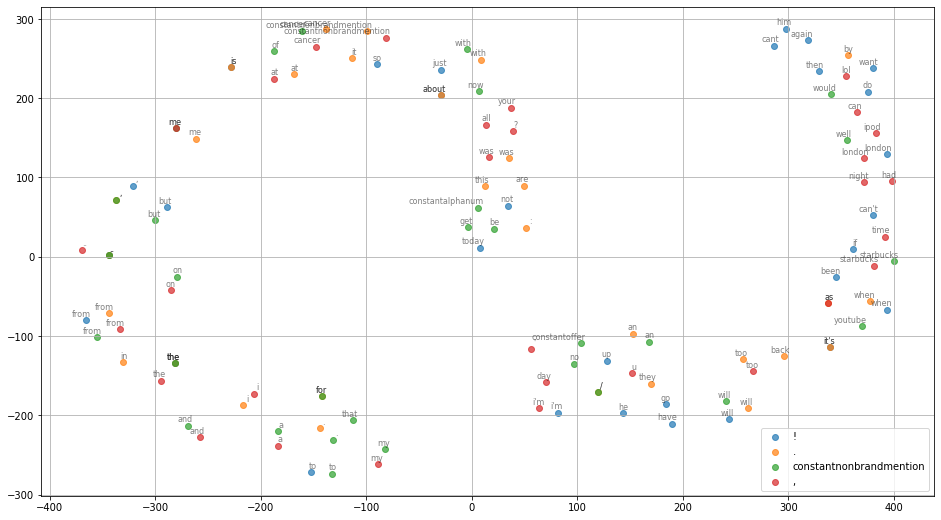

In [14]:
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))

    for label, embeddings, words in zip(labels, embedding_clusters, word_clusters):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(
                word,
                alpha=0.5,
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords="offset points",
                ha="right",
                va="bottom",
                size=8,
            )
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(words_vocab_without_sw, embeddings_en_2d, word_clusters)

## 再学習によるアプローチ

足りないデータを補うため、`text8`コーパスを使って学習したあと、Tweetのデータを使って再学習してみましょう。

In [15]:
dataset = api.load("text8")

[==================================================] 100.0% 31.6/31.6MB downloaded


まず、text8を使って学習します。

In [16]:
model = Word2Vec(dataset, min_count=5, sg=0, seed=1)

In [17]:
print("Vocabulary size: ", len(model.wv.key_to_index))

Vocabulary size:  71290


次に、Tweetを使って学習します。

In [18]:
model.build_vocab(tweets, update=True)
model.train(tweets, total_examples=model.corpus_count, epochs=model.epochs)

(115208, 169480)

ボキャブラリ数が増えていることがわかります。

In [19]:
print("Vocabulary size: ", len(model.wv.key_to_index))

Vocabulary size:  71382


In [20]:
model.wv.most_similar("constantdate")

[('-', 0.7517199516296387),
 ('constantnum', 0.7336406707763672),
 ('constanthashtag', 0.7230152487754822),
 ('constantalphanum', 0.7130792140960693),
 ('!', 0.7063228487968445),
 ('constanturl', 0.7018894553184509),
 ('.', 0.6932525634765625),
 (':', 0.6912057399749756),
 ('..', 0.6902627348899841),
 (',', 0.6856096386909485)]

[['evening', 'monday', 'week', 'parade', 'night', 'afternoon', 'sunday', 'morning', 'friday', 'saturday'], ["i'll", 'constantnonbrandmention', 'facebook', 'youtube', 'bummed', 'hayfever', 'mcdonalds', 'constanturl', 'starbucks', '-'], ['starbucks', 'constantnonbrandmention', '..', '-', ',', "i'm", 'constantalphanum', '!', '.', 'twitter'], ['sugar', 'tea', 'beef', 'beans', 'cotton', 'wheat', 'potatoes', 'bananas', 'wool', 'seafood']]


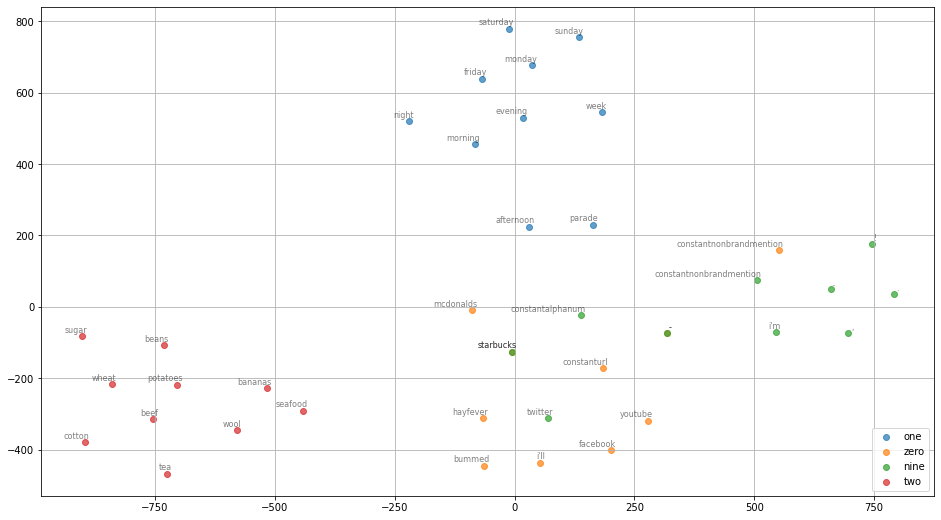

In [22]:
words_vocab = list(model.wv.key_to_index)
words_vocab_without_sw = remove_stopwords(words_vocab)
embedding_clusters, word_clusters = create_clusters(model, keys, topn=10)
print(word_clusters)
embeddings_en_2d = reduce_dimention(embedding_clusters)
tsne_plot_similar_words(words_vocab_without_sw, embeddings_en_2d, word_clusters)

gensimには学習済みのTwitterの単語埋め込みがあるので、そちらを使うのも良いでしょう。また、それ以外にも事前学習済みの埋め込みは公開されているので、探して使うのも1つの手です。

- [What is Gensim-data for?](https://github.com/RaRe-Technologies/gensim-data)
- [Twitter word embeddings](https://github.com/FredericGodin/TwitterEmbeddings)